## KMeans

PCA Reduced Dimensions: 4
K=2: Silhouette Score=0.4094566677283822
K=3: Silhouette Score=0.5821494544495751
K=4: Silhouette Score=0.6670035899934393
K=5: Silhouette Score=0.6244977858455246
K=6: Silhouette Score=0.6275020986910811
K=7: Silhouette Score=0.616791586756064
K=8: Silhouette Score=0.6029790078439804
K=9: Silhouette Score=0.5750101004886405
K=10: Silhouette Score=0.5688811603699799
Optimal number of clusters: 4
K-Means with K=4 - Davies-Bouldin Index: 0.5606333874312546, Silhouette Score: 0.6670035899934393


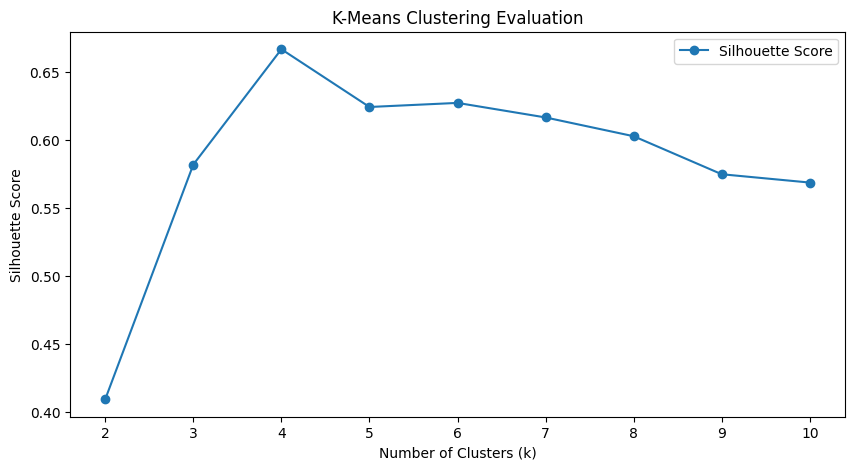

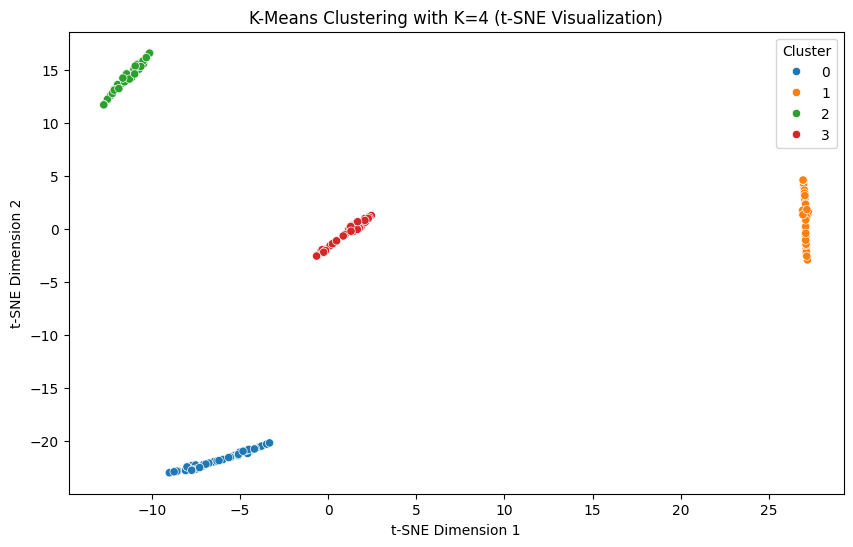

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# 1. Load and preprocess data
customers = pd.read_csv('/Volumes/DATA/Assignment/Data/Customers - Customers.csv')
transactions = pd.read_csv('/Volumes/DATA/Assignment/Data/Transactions - Transactions.csv')

# Merge datasets
data = pd.merge(transactions, customers, on='CustomerID')
aggregated = data.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'Price': 'mean'
}).reset_index()
aggregated.rename(columns={'TransactionID': 'TransactionCount'}, inplace=True)
final_data = pd.merge(aggregated, customers, on='CustomerID')
final_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1, inplace=True)
final_data = pd.get_dummies(final_data, columns=['Region'], drop_first=True)

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(final_data)

# 2. Dimensionality reduction
pca = PCA(n_components=0.90)
pca_data = pca.fit_transform(scaled_data)
print(f"PCA Reduced Dimensions: {pca_data.shape[1]}")

# 3. K-Means Clustering and evaluation
kmeans_scores = []

# Evaluate K for K-Means
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_data)
    silhouette_avg = silhouette_score(pca_data, labels)
    kmeans_scores.append(silhouette_avg)
    print(f"K={k}: Silhouette Score={silhouette_avg}")

# Determine the optimal K
optimal_k = np.argmax(kmeans_scores) + 2
print(f"Optimal number of clusters: {optimal_k}")

# Run K-Means with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters_kmeans = kmeans.fit_predict(pca_data)

# Evaluate clustering
db_index = davies_bouldin_score(pca_data, clusters_kmeans)
silhouette_avg = silhouette_score(pca_data, clusters_kmeans)
print(f"K-Means with K={optimal_k} - Davies-Bouldin Index: {db_index}, Silhouette Score: {silhouette_avg}")

# 4. Visualization
# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), kmeans_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K-Means Clustering Evaluation')
plt.legend()
plt.show()

# 5. t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(pca_data)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=clusters_kmeans, palette='tab10')
plt.title(f'K-Means Clustering with K={optimal_k} (t-SNE Visualization)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster', loc='best')
plt.show()
